In [3]:
import pandas as pd
import numpy as np
import random

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

import rdkit
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit import Chem, DataStructs

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt

import xgboost as xgb

In [4]:
RANDOM_SEED = 42

In [7]:
def feature_engineer():
  train_df = pd.read_csv("./data/train.csv")
  test_df = pd.read_csv("./data/test.csv")
  train_df["mol"] = train_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
  test_df["mol"] = test_df["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))
  
  train_df.drop(columns=["id", "SMILES"], inplace=True)
  test_df.drop(columns=["id", "SMILES"], inplace=True)
  
  
  fmgen = rdFingerprintGenerator.GetMorganGenerator()
  train_fps = train_df["mol"].apply(lambda x: fmgen.GetFingerprintAsNumPy(x))
  train_fps = np.stack(train_fps)
  test_fps = test_df["mol"].apply(lambda x: fmgen.GetFingerprintAsNumPy(x))
  test_fps = np.stack(test_fps)
  
  origin_train_features = train_df[["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]].values
  origin_test_features = test_df[["AlogP", "Molecular_Weight", "Num_H_Acceptors", "Num_H_Donors", "Num_RotatableBonds", "LogD", "Molecular_PolarSurfaceArea"]].values
  
  train_features = np.append(origin_train_features, train_fps, axis=1)
  test_features = np.append(origin_test_features, test_fps, axis=1)
  target = train_df["MLM"].values
  
  return train_features, target, test_features
  

In [8]:
train_x, train_y, test_x = feature_engineer()

In [9]:
def create_model(param):
  return xgb.XGBRegressor(
    random_state=RANDOM_SEED,
    tree_method="gpu_hist",
    eval_metric="rmse",
    early_stopping_rounds=50,
    **param
  )

In [10]:
def train_model(param, X, y, X_test, trial=None):
    skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    val_scores = []
    y_tests = []
    models = []

    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        model = create_model(param)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=1000)

        y_hat_val = model.predict(X_val)
        score = mean_squared_error(y_val, y_hat_val, squared=True)
        val_scores.append(score)
        print(f'Fold: {idx+1}/5 score = {score:.5f}')

        y_tests.append(model.predict(X_test))
        models.append(model)

        if trial:
            trial.report(score, idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

    return val_scores, y_tests, models

In [11]:
def objective_xgb(trial):
    param = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    }

    if param["booster"] == "dart":
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    val_scores, y_tests, models = train_model(param, train_x, train_y, test_x, trial)

    return sum(val_scores) / len(val_scores)

In [12]:
study = optuna.create_study(
    sampler=TPESampler(seed=RANDOM_SEED),
    direction='minimize',
    study_name='xgb_tuning',
    pruner=HyperbandPruner(
        min_resource=1, max_resource=8, reduction_factor=3
    ),
)

study.optimize(objective_xgb, n_trials=100)

[I 2023-08-17 16:32:15,863] A new study created in memory with name: xgb_tuning


[0]	validation_0-rmse:50.98355	validation_1-rmse:52.01123
[99]	validation_0-rmse:40.43717	validation_1-rmse:42.38212
Fold: 1/5 score = 1796.24405
[0]	validation_0-rmse:50.48315	validation_1-rmse:53.98357
[99]	validation_0-rmse:40.19955	validation_1-rmse:43.92678
Fold: 2/5 score = 1929.56236
[0]	validation_0-rmse:51.45789	validation_1-rmse:50.11414
[99]	validation_0-rmse:40.98397	validation_1-rmse:40.02995
Fold: 3/5 score = 1602.39658
[0]	validation_0-rmse:51.30739	validation_1-rmse:50.73809
[99]	validation_0-rmse:40.84358	validation_1-rmse:40.63700
Fold: 4/5 score = 1651.36592
[0]	validation_0-rmse:51.71924	validation_1-rmse:48.98052
[99]	validation_0-rmse:40.98622	validation_1-rmse:39.29252
Fold: 5/5 score = 1543.90217


[I 2023-08-17 16:32:55,136] Trial 0 finished with value: 1704.694215564939 and parameters: {'booster': 'dart', 'lambda': 0.007177141927992002, 'alpha': 0.0006155564318973012, 'subsample': 0.24041677639819287, 'colsample_bytree': 0.2403950683025824, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.004619347374377372, 'gamma': 1.4610865886287176e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00015777981883364995, 'skip_drop': 2.85469785779718e-05}. Best is trial 0 with value: 1704.694215564939.


[0]	validation_0-rmse:51.10227	validation_1-rmse:52.12406
[799]	validation_0-rmse:40.76321	validation_1-rmse:42.51230
Fold: 1/5 score = 1807.29536
[0]	validation_0-rmse:50.58859	validation_1-rmse:54.09132
[799]	validation_0-rmse:40.52118	validation_1-rmse:44.11498
Fold: 2/5 score = 1946.13127
[0]	validation_0-rmse:51.57394	validation_1-rmse:50.22936
[799]	validation_0-rmse:41.27051	validation_1-rmse:40.05899
Fold: 3/5 score = 1604.72286
[0]	validation_0-rmse:51.42142	validation_1-rmse:50.85304
[799]	validation_0-rmse:41.21002	validation_1-rmse:40.67425
Fold: 4/5 score = 1654.39460
[0]	validation_0-rmse:51.84500	validation_1-rmse:49.09808
[799]	validation_0-rmse:41.39511	validation_1-rmse:39.41916
Fold: 5/5 score = 1553.86991


[I 2023-08-17 17:08:55,442] Trial 1 finished with value: 1713.2827987879914 and parameters: {'booster': 'dart', 'lambda': 1.3060231803531604e-07, 'alpha': 2.1734877073417355e-06, 'subsample': 0.4297256589643226, 'colsample_bytree': 0.5104629857953323, 'n_estimators': 800, 'max_depth': 4, 'min_child_weight': 6, 'eta': 0.0005486767416600901, 'gamma': 2.3528990899815284e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.734702913886802e-06, 'skip_drop': 6.044730070370796e-08}. Best is trial 0 with value: 1704.694215564939.


[0]	validation_0-rmse:51.11530	validation_1-rmse:52.13678
[299]	validation_0-rmse:49.75084	validation_1-rmse:50.87072
Fold: 1/5 score = 2587.83026
[0]	validation_0-rmse:50.60094	validation_1-rmse:54.10303
[299]	validation_0-rmse:49.27149	validation_1-rmse:52.80499
Fold: 2/5 score = 2788.36697
[0]	validation_0-rmse:51.58725	validation_1-rmse:50.24302
[299]	validation_0-rmse:50.22857	validation_1-rmse:48.88983
Fold: 3/5 score = 2390.21559
[0]	validation_0-rmse:51.43436	validation_1-rmse:50.86620
[299]	validation_0-rmse:50.08485	validation_1-rmse:49.52163


[I 2023-08-17 17:09:11,431] Trial 2 pruned. 


Fold: 4/5 score = 2452.39221
[0]	validation_0-rmse:51.11933	validation_1-rmse:52.14049
[199]	validation_0-rmse:51.04532	validation_1-rmse:52.06919
Fold: 1/5 score = 2711.20033
[0]	validation_0-rmse:50.60539	validation_1-rmse:54.10734
[199]	validation_0-rmse:50.53332	validation_1-rmse:54.03467
Fold: 2/5 score = 2919.74595


[I 2023-08-17 17:10:08,749] Trial 3 pruned. 


[0]	validation_0-rmse:51.11969	validation_1-rmse:52.14084
[799]	validation_0-rmse:51.11758	validation_1-rmse:52.13882
Fold: 1/5 score = 2718.45686
[0]	validation_0-rmse:50.60575	validation_1-rmse:54.10769
[799]	validation_0-rmse:50.60369	validation_1-rmse:54.10564
Fold: 2/5 score = 2927.42041
[0]	validation_0-rmse:51.59186	validation_1-rmse:50.24753
[799]	validation_0-rmse:51.58976	validation_1-rmse:50.24540
Fold: 3/5 score = 2524.59975
[0]	validation_0-rmse:51.43868	validation_1-rmse:50.87059
[799]	validation_0-rmse:51.43659	validation_1-rmse:50.86846


[I 2023-08-17 17:10:20,377] Trial 4 pruned. 


Fold: 4/5 score = 2587.60069
[0]	validation_0-rmse:50.73804	validation_1-rmse:51.77555
[499]	validation_0-rmse:27.93193	validation_1-rmse:32.69985
Fold: 1/5 score = 1069.18023
[0]	validation_0-rmse:50.22932	validation_1-rmse:53.73419
[499]	validation_0-rmse:28.00438	validation_1-rmse:32.58254
Fold: 2/5 score = 1061.62159
[0]	validation_0-rmse:51.20595	validation_1-rmse:49.85507
[499]	validation_0-rmse:28.46902	validation_1-rmse:30.30190
Fold: 3/5 score = 918.18395
[0]	validation_0-rmse:51.05945	validation_1-rmse:50.48725
[499]	validation_0-rmse:28.52846	validation_1-rmse:30.05484
Fold: 4/5 score = 903.29320
[0]	validation_0-rmse:51.47565	validation_1-rmse:48.74611
[499]	validation_0-rmse:28.40487	validation_1-rmse:30.52020
Fold: 5/5 score = 931.48271


[I 2023-08-17 17:24:34,680] Trial 5 finished with value: 976.7523359631439 and parameters: {'booster': 'dart', 'lambda': 3.994538177154855e-06, 'alpha': 0.006868302692995721, 'subsample': 0.6738017242196918, 'colsample_bytree': 0.8984914683186939, 'n_estimators': 500, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.012197768563438372, 'gamma': 0.0003091844051450647, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.784158714232739e-08, 'skip_drop': 0.0012339094493965515}. Best is trial 5 with value: 976.7523359631439.


[0]	validation_0-rmse:51.11969	validation_1-rmse:52.14083
[299]	validation_0-rmse:51.11786	validation_1-rmse:52.13910
Fold: 1/5 score = 2718.48531
[0]	validation_0-rmse:50.60574	validation_1-rmse:54.10769
[299]	validation_0-rmse:50.60396	validation_1-rmse:54.10592
Fold: 2/5 score = 2927.45062


[I 2023-08-17 17:26:44,515] Trial 6 pruned. 


[0]	validation_0-rmse:51.11901	validation_1-rmse:52.14019
[899]	validation_0-rmse:50.51113	validation_1-rmse:51.55939
Fold: 1/5 score = 2658.37091
[0]	validation_0-rmse:50.60507	validation_1-rmse:54.10702
[899]	validation_0-rmse:50.01157	validation_1-rmse:53.51609


[I 2023-08-17 17:26:51,593] Trial 7 pruned. 


Fold: 2/5 score = 2863.97179
[0]	validation_0-rmse:51.11961	validation_1-rmse:52.14077
[999]	validation_0-rmse:51.03789	validation_1-rmse:52.06368
Fold: 1/5 score = 2710.62679
[0]	validation_0-rmse:50.60567	validation_1-rmse:54.10761
[999]	validation_0-rmse:50.52601	validation_1-rmse:54.02920
Fold: 2/5 score = 2919.15397
[0]	validation_0-rmse:51.59179	validation_1-rmse:50.24745
[999]	validation_0-rmse:51.51029	validation_1-rmse:50.16577
Fold: 3/5 score = 2516.60401
[0]	validation_0-rmse:51.43860	validation_1-rmse:50.87051
[999]	validation_0-rmse:51.35788	validation_1-rmse:50.78895


[I 2023-08-17 17:27:15,220] Trial 8 pruned. 


Fold: 4/5 score = 2579.51757
[0]	validation_0-rmse:51.04347	validation_1-rmse:52.07268
[499]	validation_0-rmse:31.69968	validation_1-rmse:35.88629
Fold: 1/5 score = 1287.82607
[0]	validation_0-rmse:50.53226	validation_1-rmse:54.03772
[499]	validation_0-rmse:31.74610	validation_1-rmse:36.69970
Fold: 2/5 score = 1346.86777
[0]	validation_0-rmse:51.52060	validation_1-rmse:50.18088
[499]	validation_0-rmse:32.24949	validation_1-rmse:33.19682
Fold: 3/5 score = 1102.02868
[0]	validation_0-rmse:51.36274	validation_1-rmse:50.79618
[499]	validation_0-rmse:32.33282	validation_1-rmse:33.73577


[I 2023-08-17 17:27:46,233] Trial 9 pruned. 


Fold: 4/5 score = 1138.10212
[0]	validation_0-rmse:36.98971	validation_1-rmse:39.70031
[350]	validation_0-rmse:26.16274	validation_1-rmse:32.56855
Fold: 1/5 score = 1077.30833
[0]	validation_0-rmse:36.84533	validation_1-rmse:40.99477
[151]	validation_0-rmse:26.42622	validation_1-rmse:32.24312
Fold: 2/5 score = 1138.46087
[0]	validation_0-rmse:37.24688	validation_1-rmse:36.82287
[355]	validation_0-rmse:26.66154	validation_1-rmse:30.27022
Fold: 3/5 score = 920.67579
[0]	validation_0-rmse:37.43947	validation_1-rmse:36.99923
[117]	validation_0-rmse:26.89579	validation_1-rmse:30.03115
Fold: 4/5 score = 1001.46198
[0]	validation_0-rmse:37.64505	validation_1-rmse:36.57375
[319]	validation_0-rmse:26.64254	validation_1-rmse:30.33718
Fold: 5/5 score = 921.95080


[I 2023-08-17 17:31:54,160] Trial 10 finished with value: 1011.9715522801046 and parameters: {'booster': 'dart', 'lambda': 1.1177206837443211e-05, 'alpha': 0.5705541732383875, 'subsample': 0.6758183738140613, 'colsample_bytree': 0.6090517816132627, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.4873745203681325, 'gamma': 0.000645467831303796, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.3331912580301703, 'skip_drop': 0.00042115877464331166}. Best is trial 5 with value: 976.7523359631439.


[0]	validation_0-rmse:38.60467	validation_1-rmse:41.25198
[560]	validation_0-rmse:28.25302	validation_1-rmse:32.89934
Fold: 1/5 score = 1090.56405
[0]	validation_0-rmse:38.41711	validation_1-rmse:42.46735
[599]	validation_0-rmse:28.41293	validation_1-rmse:32.77597
Fold: 2/5 score = 1075.32443
[0]	validation_0-rmse:38.86651	validation_1-rmse:38.20854
[384]	validation_0-rmse:28.77615	validation_1-rmse:30.61216
Fold: 3/5 score = 943.46345
[0]	validation_0-rmse:38.86135	validation_1-rmse:38.31973
[208]	validation_0-rmse:28.98142	validation_1-rmse:30.49340
Fold: 4/5 score = 964.36244
[0]	validation_0-rmse:39.26896	validation_1-rmse:38.00690
[315]	validation_0-rmse:28.84050	validation_1-rmse:30.70667
Fold: 5/5 score = 948.15226


[I 2023-08-17 17:40:19,287] Trial 11 finished with value: 1004.3733241816956 and parameters: {'booster': 'dart', 'lambda': 1.656077948267287e-05, 'alpha': 0.9802663137825812, 'subsample': 0.6977582128155022, 'colsample_bytree': 0.6298933988523241, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 10, 'eta': 0.42156870021976606, 'gamma': 0.0010047809013524105, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.7299655753655673, 'skip_drop': 0.0009025783926527956}. Best is trial 5 with value: 976.7523359631439.


[0]	validation_0-rmse:33.74198	validation_1-rmse:37.15789
[100]	validation_0-rmse:28.53381	validation_1-rmse:32.93091
Fold: 1/5 score = 1333.19324
[0]	validation_0-rmse:33.70848	validation_1-rmse:37.95393
[176]	validation_0-rmse:28.70127	validation_1-rmse:32.88076
Fold: 2/5 score = 1209.17274
[0]	validation_0-rmse:34.03863	validation_1-rmse:34.20394
[207]	validation_0-rmse:29.02019	validation_1-rmse:30.68061
Fold: 3/5 score = 982.38820
[0]	validation_0-rmse:34.40680	validation_1-rmse:34.21122
[108]	validation_0-rmse:29.27885	validation_1-rmse:30.64328
Fold: 4/5 score = 1141.20925


[I 2023-08-17 17:41:11,745] Trial 12 pruned. 


[0]	validation_0-rmse:49.96027	validation_1-rmse:51.10945
[294]	validation_0-rmse:18.84101	validation_1-rmse:32.46088
Fold: 1/5 score = 1048.86898
[0]	validation_0-rmse:49.47517	validation_1-rmse:53.03877
[267]	validation_0-rmse:19.55440	validation_1-rmse:32.39786
Fold: 2/5 score = 1047.53715
[0]	validation_0-rmse:50.41041	validation_1-rmse:49.12169
[274]	validation_0-rmse:19.87069	validation_1-rmse:30.05849
Fold: 3/5 score = 902.07468
[0]	validation_0-rmse:50.25976	validation_1-rmse:49.71180
[288]	validation_0-rmse:19.46229	validation_1-rmse:29.82679
Fold: 4/5 score = 888.56203
[0]	validation_0-rmse:50.68503	validation_1-rmse:48.06367
[271]	validation_0-rmse:19.76420	validation_1-rmse:29.80972
Fold: 5/5 score = 885.43757


[I 2023-08-17 17:45:52,098] Trial 13 finished with value: 954.4960826445313 and parameters: {'booster': 'dart', 'lambda': 0.0004115646636381647, 'alpha': 0.02275951027248166, 'subsample': 0.7900221692433886, 'colsample_bytree': 0.48700934236258314, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.034769614608622636, 'gamma': 4.961917338227354e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1423603259887504e-08, 'skip_drop': 2.9612090978670148e-05}. Best is trial 13 with value: 954.4960826445313.


[0]	validation_0-rmse:50.34089	validation_1-rmse:51.43675
[293]	validation_0-rmse:20.62230	validation_1-rmse:32.33831
Fold: 1/5 score = 1043.61105
[0]	validation_0-rmse:49.84711	validation_1-rmse:53.38859
[399]	validation_0-rmse:19.14724	validation_1-rmse:32.39624
Fold: 2/5 score = 1047.54426
[0]	validation_0-rmse:50.79495	validation_1-rmse:49.48053
[265]	validation_0-rmse:21.72825	validation_1-rmse:30.19002
Fold: 3/5 score = 910.42779
[0]	validation_0-rmse:50.64585	validation_1-rmse:50.09267
[399]	validation_0-rmse:19.64893	validation_1-rmse:29.64790
Fold: 4/5 score = 878.77321
[0]	validation_0-rmse:51.07081	validation_1-rmse:48.40810
[399]	validation_0-rmse:19.56217	validation_1-rmse:29.85009
Fold: 5/5 score = 890.82544


[I 2023-08-17 17:53:16,190] Trial 14 finished with value: 954.2363503801928 and parameters: {'booster': 'dart', 'lambda': 0.0006762676686783942, 'alpha': 0.01609159480975798, 'subsample': 0.8371995306578522, 'colsample_bytree': 0.4925855539333315, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.023281960539576443, 'gamma': 4.1004152149798e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.4812209254251174e-08, 'skip_drop': 4.731543457571597e-06}. Best is trial 14 with value: 954.2363503801928.


[0]	validation_0-rmse:49.93358	validation_1-rmse:51.12241
[256]	validation_0-rmse:13.09946	validation_1-rmse:32.76037
Fold: 1/5 score = 1069.24181
[0]	validation_0-rmse:49.44770	validation_1-rmse:53.08001
[226]	validation_0-rmse:14.01484	validation_1-rmse:32.69933
Fold: 2/5 score = 1065.52455
[0]	validation_0-rmse:50.38329	validation_1-rmse:49.13490
[193]	validation_0-rmse:15.40667	validation_1-rmse:30.24334
Fold: 3/5 score = 911.23468
[0]	validation_0-rmse:50.24167	validation_1-rmse:49.77012
[248]	validation_0-rmse:13.86035	validation_1-rmse:29.80100
Fold: 4/5 score = 885.33470
[0]	validation_0-rmse:50.64863	validation_1-rmse:48.07882
[220]	validation_0-rmse:14.28686	validation_1-rmse:30.07999
Fold: 5/5 score = 903.07394


[I 2023-08-17 17:56:30,731] Trial 15 finished with value: 966.8819338854988 and parameters: {'booster': 'dart', 'lambda': 0.0010400774602416522, 'alpha': 0.04120391548740278, 'subsample': 0.8920908906954158, 'colsample_bytree': 0.43381159243521583, 'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.034062941139685554, 'gamma': 2.8501143711630568e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9630739918526997e-08, 'skip_drop': 3.86333121797938e-06}. Best is trial 14 with value: 954.2363503801928.


[0]	validation_0-rmse:49.32643	validation_1-rmse:50.54414
[167]	validation_0-rmse:19.66857	validation_1-rmse:32.25208
Fold: 1/5 score = 1037.66947
[0]	validation_0-rmse:48.86619	validation_1-rmse:52.45612
[183]	validation_0-rmse:19.16252	validation_1-rmse:32.42064
Fold: 2/5 score = 1045.10372
[0]	validation_0-rmse:49.76686	validation_1-rmse:48.50828
[223]	validation_0-rmse:18.62385	validation_1-rmse:30.03113
Fold: 3/5 score = 894.87590
[0]	validation_0-rmse:49.61942	validation_1-rmse:49.15592
[241]	validation_0-rmse:18.04355	validation_1-rmse:29.67055
Fold: 4/5 score = 876.60151
[0]	validation_0-rmse:50.05397	validation_1-rmse:47.47320
[249]	validation_0-rmse:18.01071	validation_1-rmse:29.76919
Fold: 5/5 score = 882.95447


[I 2023-08-17 17:59:18,637] Trial 16 finished with value: 947.4410144296698 and parameters: {'booster': 'dart', 'lambda': 0.0026377247595962727, 'alpha': 7.483780511102761e-05, 'subsample': 0.8280537243135858, 'colsample_bytree': 0.37588574594589486, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.05393761227911353, 'gamma': 4.291867724531988e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.145690154427874e-07, 'skip_drop': 1.3546656519467045e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:51.09032	validation_1-rmse:52.11355
[299]	validation_0-rmse:43.78643	validation_1-rmse:45.65201
Fold: 1/5 score = 2084.10604
[0]	validation_0-rmse:50.57698	validation_1-rmse:54.08174
[299]	validation_0-rmse:43.44377	validation_1-rmse:47.40085
Fold: 2/5 score = 2246.84071


[I 2023-08-17 18:01:26,051] Trial 17 pruned. 


[0]	validation_0-rmse:49.32765	validation_1-rmse:50.43020
[247]	validation_0-rmse:22.41045	validation_1-rmse:32.57214
Fold: 1/5 score = 1059.78087
[0]	validation_0-rmse:48.87358	validation_1-rmse:52.34994
[293]	validation_0-rmse:21.77035	validation_1-rmse:32.50962
Fold: 2/5 score = 1051.63885
[0]	validation_0-rmse:49.77368	validation_1-rmse:48.47540
[259]	validation_0-rmse:22.64957	validation_1-rmse:30.39951
Fold: 3/5 score = 917.18914
[0]	validation_0-rmse:49.63396	validation_1-rmse:49.06344
[367]	validation_0-rmse:21.12347	validation_1-rmse:29.66445
Fold: 4/5 score = 878.06704
[0]	validation_0-rmse:50.05798	validation_1-rmse:47.43278
[356]	validation_0-rmse:21.13430	validation_1-rmse:30.21699
Fold: 5/5 score = 912.05758


[I 2023-08-17 18:07:05,385] Trial 18 finished with value: 963.7466969253835 and parameters: {'booster': 'dart', 'lambda': 0.01577856402756374, 'alpha': 4.5396233208247835e-05, 'subsample': 0.8358713998596361, 'colsample_bytree': 0.11295452826394886, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0634785024134716, 'gamma': 9.385435283793485e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.869989362098473e-07, 'skip_drop': 2.257598346321336e-08}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.93077	validation_1-rmse:51.97269
[99]	validation_0-rmse:37.91337	validation_1-rmse:40.74870
Fold: 1/5 score = 1660.45648
[0]	validation_0-rmse:50.42042	validation_1-rmse:53.93499
[99]	validation_0-rmse:37.75127	validation_1-rmse:42.23883
Fold: 2/5 score = 1784.11862


[I 2023-08-17 18:07:20,935] Trial 19 pruned. 


[0]	validation_0-rmse:44.86198	validation_1-rmse:46.61957
[76]	validation_0-rmse:14.62575	validation_1-rmse:33.33046
Fold: 1/5 score = 1090.79996
[0]	validation_0-rmse:44.52708	validation_1-rmse:48.60829
[85]	validation_0-rmse:13.78012	validation_1-rmse:33.51435
Fold: 2/5 score = 1099.80797
[0]	validation_0-rmse:45.27742	validation_1-rmse:44.28394
[71]	validation_0-rmse:15.27439	validation_1-rmse:30.92074
Fold: 3/5 score = 927.65675
[0]	validation_0-rmse:45.18445	validation_1-rmse:45.03245
[69]	validation_0-rmse:15.74924	validation_1-rmse:30.17158
Fold: 4/5 score = 883.97950
[0]	validation_0-rmse:45.55827	validation_1-rmse:43.41530
[66]	validation_0-rmse:15.46761	validation_1-rmse:30.92310


[I 2023-08-17 18:07:42,835] Trial 20 finished with value: 990.0465050138852 and parameters: {'booster': 'dart', 'lambda': 0.6485964975212271, 'alpha': 0.0007187209958833317, 'subsample': 0.9928522833123985, 'colsample_bytree': 0.3803401941100095, 'n_estimators': 700, 'max_depth': 8, 'min_child_weight': 7, 'eta': 0.1914437474153969, 'gamma': 9.84603559331648e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 8.034900469625193e-06, 'skip_drop': 2.3713016061923255e-07}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 947.98835
[0]	validation_0-rmse:50.04418	validation_1-rmse:51.17737
[227]	validation_0-rmse:20.60348	validation_1-rmse:32.41180
Fold: 1/5 score = 1048.09498
[0]	validation_0-rmse:49.54510	validation_1-rmse:53.09150
[240]	validation_0-rmse:20.43499	validation_1-rmse:32.46866
Fold: 2/5 score = 1050.07652
[0]	validation_0-rmse:50.48666	validation_1-rmse:49.22261
[355]	validation_0-rmse:18.48510	validation_1-rmse:29.94165
Fold: 3/5 score = 890.72706
[0]	validation_0-rmse:50.34013	validation_1-rmse:49.77897
[236]	validation_0-rmse:20.84545	validation_1-rmse:29.77307
Fold: 4/5 score = 883.93513
[0]	validation_0-rmse:50.75852	validation_1-rmse:48.12192
[344]	validation_0-rmse:18.58175	validation_1-rmse:29.81997
Fold: 5/5 score = 886.02363


[I 2023-08-17 18:12:32,607] Trial 21 finished with value: 951.7714630689889 and parameters: {'booster': 'dart', 'lambda': 0.0003813359914475584, 'alpha': 0.0040198844687749915, 'subsample': 0.8077258291772774, 'colsample_bytree': 0.5052689768238193, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.032352419449280634, 'gamma': 9.7409040368301e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.2100059663303176e-08, 'skip_drop': 9.747266725154733e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:47.85326	validation_1-rmse:49.26390
[121]	validation_0-rmse:17.90075	validation_1-rmse:32.28005
Fold: 1/5 score = 1041.30048
[0]	validation_0-rmse:47.40622	validation_1-rmse:51.12486
[115]	validation_0-rmse:18.46656	validation_1-rmse:32.41849
Fold: 2/5 score = 1039.55397
[0]	validation_0-rmse:48.24085	validation_1-rmse:47.01305
[151]	validation_0-rmse:17.09919	validation_1-rmse:30.51544
Fold: 3/5 score = 916.34057
[0]	validation_0-rmse:48.12198	validation_1-rmse:47.61284
[110]	validation_0-rmse:19.11979	validation_1-rmse:29.99485
Fold: 4/5 score = 890.90948


[I 2023-08-17 18:13:19,800] Trial 22 pruned. 


[0]	validation_0-rmse:50.74508	validation_1-rmse:51.79513
[199]	validation_0-rmse:28.22347	validation_1-rmse:33.14699
Fold: 1/5 score = 1098.72317
[0]	validation_0-rmse:50.23546	validation_1-rmse:53.74579
[199]	validation_0-rmse:28.26071	validation_1-rmse:33.41377
Fold: 2/5 score = 1116.48024


[I 2023-08-17 18:14:17,693] Trial 23 pruned. 


[0]	validation_0-rmse:47.61760	validation_1-rmse:49.16429
[112]	validation_0-rmse:16.35808	validation_1-rmse:32.92934
Fold: 1/5 score = 1054.90769
[0]	validation_0-rmse:47.19452	validation_1-rmse:50.84929
[108]	validation_0-rmse:16.58038	validation_1-rmse:32.54017
Fold: 2/5 score = 1038.42797
[0]	validation_0-rmse:48.13140	validation_1-rmse:47.03303
[95]	validation_0-rmse:17.79185	validation_1-rmse:30.80310
Fold: 3/5 score = 936.09592
[0]	validation_0-rmse:47.98121	validation_1-rmse:47.50865
[141]	validation_0-rmse:15.23629	validation_1-rmse:30.46770
Fold: 4/5 score = 913.35032


[I 2023-08-17 18:14:58,268] Trial 24 pruned. 


[0]	validation_0-rmse:50.45147	validation_1-rmse:51.54029
[199]	validation_0-rmse:25.11114	validation_1-rmse:32.49438
Fold: 1/5 score = 1055.88442
[0]	validation_0-rmse:49.95034	validation_1-rmse:53.48420
[199]	validation_0-rmse:25.53010	validation_1-rmse:32.53008
Fold: 2/5 score = 1058.01622
[0]	validation_0-rmse:50.91537	validation_1-rmse:49.58603
[199]	validation_0-rmse:25.65017	validation_1-rmse:30.09658
Fold: 3/5 score = 905.52653
[0]	validation_0-rmse:50.77648	validation_1-rmse:50.21299
[199]	validation_0-rmse:25.86511	validation_1-rmse:30.01540
Fold: 4/5 score = 900.10787


[I 2023-08-17 18:16:53,442] Trial 25 pruned. 


[0]	validation_0-rmse:30.02418	validation_1-rmse:35.41652
[50]	validation_0-rmse:16.45162	validation_1-rmse:43.64049
Fold: 1/5 score = 1254.32996
[0]	validation_0-rmse:30.35448	validation_1-rmse:35.15429
[51]	validation_0-rmse:15.75518	validation_1-rmse:44.67826


[I 2023-08-17 18:16:54,977] Trial 26 pruned. 


Fold: 2/5 score = 1231.87436
[0]	validation_0-rmse:51.07114	validation_1-rmse:52.09535
[499]	validation_0-rmse:36.07740	validation_1-rmse:38.74968
Fold: 1/5 score = 1501.53796
[0]	validation_0-rmse:50.55841	validation_1-rmse:54.06152
[499]	validation_0-rmse:35.94621	validation_1-rmse:40.03128
Fold: 2/5 score = 1602.50296
[0]	validation_0-rmse:51.54317	validation_1-rmse:50.19864
[499]	validation_0-rmse:36.53548	validation_1-rmse:36.12490
Fold: 3/5 score = 1305.00817
[0]	validation_0-rmse:51.39051	validation_1-rmse:50.82183
[499]	validation_0-rmse:36.57070	validation_1-rmse:36.64516
Fold: 4/5 score = 1342.86772


[I 2023-08-17 18:28:14,620] Trial 27 pruned. 


[0]	validation_0-rmse:50.80932	validation_1-rmse:51.85585
[587]	validation_0-rmse:20.53526	validation_1-rmse:32.46213
Fold: 1/5 score = 1053.08775
[0]	validation_0-rmse:50.29588	validation_1-rmse:53.79978
[584]	validation_0-rmse:20.67315	validation_1-rmse:32.21436
Fold: 2/5 score = 1037.53530
[0]	validation_0-rmse:51.27191	validation_1-rmse:49.93864
[477]	validation_0-rmse:22.06866	validation_1-rmse:29.95296
Fold: 3/5 score = 895.40396
[0]	validation_0-rmse:51.13364	validation_1-rmse:50.57159
[699]	validation_0-rmse:20.01283	validation_1-rmse:29.53726
Fold: 4/5 score = 872.30239
[0]	validation_0-rmse:51.53908	validation_1-rmse:48.82761
[699]	validation_0-rmse:19.89956	validation_1-rmse:29.95007
Fold: 5/5 score = 896.28561


[I 2023-08-17 18:50:26,435] Trial 28 finished with value: 950.9230014857078 and parameters: {'booster': 'dart', 'lambda': 4.2374480987417556e-05, 'alpha': 0.0019138160466205738, 'subsample': 0.6001724763521068, 'colsample_bytree': 0.28375747413678976, 'n_estimators': 700, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.010611765900639858, 'gamma': 0.0005092596102992262, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.7527153040389626e-07, 'skip_drop': 8.327262295808454e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.95694	validation_1-rmse:51.99926
[699]	validation_0-rmse:22.48258	validation_1-rmse:32.48985
Fold: 1/5 score = 1055.59011
[0]	validation_0-rmse:50.44497	validation_1-rmse:53.95393
[699]	validation_0-rmse:22.60075	validation_1-rmse:32.45177
Fold: 2/5 score = 1053.11763
[0]	validation_0-rmse:51.43099	validation_1-rmse:50.09052
[699]	validation_0-rmse:22.91607	validation_1-rmse:30.04365
Fold: 3/5 score = 902.62121
[0]	validation_0-rmse:51.28421	validation_1-rmse:50.71923
[699]	validation_0-rmse:23.05660	validation_1-rmse:29.80452
Fold: 4/5 score = 888.30947


[I 2023-08-17 19:12:54,369] Trial 29 pruned. 


[0]	validation_0-rmse:47.51234	validation_1-rmse:48.95493
[89]	validation_0-rmse:13.24845	validation_1-rmse:33.48006
Fold: 1/5 score = 1108.78415
[0]	validation_0-rmse:47.15887	validation_1-rmse:50.81682
[85]	validation_0-rmse:13.70404	validation_1-rmse:32.86171
Fold: 2/5 score = 1051.72034
[0]	validation_0-rmse:47.88988	validation_1-rmse:46.66760
[96]	validation_0-rmse:13.12564	validation_1-rmse:30.84691
Fold: 3/5 score = 932.17642
[0]	validation_0-rmse:47.84996	validation_1-rmse:47.59441
[126]	validation_0-rmse:11.25813	validation_1-rmse:30.79337
Fold: 4/5 score = 928.71304


[I 2023-08-17 19:13:25,712] Trial 30 pruned. 


[0]	validation_0-rmse:50.64125	validation_1-rmse:51.69552
[399]	validation_0-rmse:19.35904	validation_1-rmse:32.39648
Fold: 1/5 score = 1049.40505
[0]	validation_0-rmse:50.13332	validation_1-rmse:53.67898
[399]	validation_0-rmse:19.33419	validation_1-rmse:32.23945
Fold: 2/5 score = 1039.06874
[0]	validation_0-rmse:51.10579	validation_1-rmse:49.79208
[399]	validation_0-rmse:19.74659	validation_1-rmse:30.03456
Fold: 3/5 score = 901.57970
[0]	validation_0-rmse:50.95359	validation_1-rmse:50.40441
[399]	validation_0-rmse:19.85316	validation_1-rmse:29.51216
Fold: 4/5 score = 870.96737
[0]	validation_0-rmse:51.37996	validation_1-rmse:48.69025
[399]	validation_0-rmse:19.59337	validation_1-rmse:30.02939
Fold: 5/5 score = 900.22196


[I 2023-08-17 19:22:56,308] Trial 31 finished with value: 952.2485634209963 and parameters: {'booster': 'dart', 'lambda': 0.00037330154124299024, 'alpha': 0.016698062631054382, 'subsample': 0.7795002808277884, 'colsample_bytree': 0.4036629629468833, 'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.014056880687838409, 'gamma': 0.00028434072740068494, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.938738422124027e-08, 'skip_drop': 1.2807447230150285e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.98847	validation_1-rmse:52.02240
[799]	validation_0-rmse:22.80290	validation_1-rmse:32.51685
Fold: 1/5 score = 1057.34521
[0]	validation_0-rmse:50.47733	validation_1-rmse:53.98544
[799]	validation_0-rmse:22.98278	validation_1-rmse:32.59527
Fold: 2/5 score = 1062.45142
[0]	validation_0-rmse:51.45849	validation_1-rmse:50.12610
[799]	validation_0-rmse:23.24942	validation_1-rmse:30.13108
Fold: 3/5 score = 907.76307
[0]	validation_0-rmse:51.30498	validation_1-rmse:50.73935
[799]	validation_0-rmse:23.45702	validation_1-rmse:29.85543
Fold: 4/5 score = 891.34655


[I 2023-08-17 19:52:39,212] Trial 32 pruned. 


[0]	validation_0-rmse:51.10507	validation_1-rmse:52.12880
[599]	validation_0-rmse:43.37386	validation_1-rmse:45.52293
Fold: 1/5 score = 2072.33695
[0]	validation_0-rmse:50.59181	validation_1-rmse:54.09467
[599]	validation_0-rmse:43.03705	validation_1-rmse:47.27852
Fold: 2/5 score = 2235.25802
[0]	validation_0-rmse:51.57735	validation_1-rmse:50.23420
[599]	validation_0-rmse:43.82652	validation_1-rmse:43.25021
Fold: 3/5 score = 1870.58095
[0]	validation_0-rmse:51.42452	validation_1-rmse:50.85714
[599]	validation_0-rmse:43.76523	validation_1-rmse:43.88069
Fold: 4/5 score = 1925.51540


[I 2023-08-17 20:09:24,741] Trial 33 pruned. 


[0]	validation_0-rmse:50.80194	validation_1-rmse:51.85581
[299]	validation_0-rmse:23.96278	validation_1-rmse:32.61290
Fold: 1/5 score = 1063.60124
[0]	validation_0-rmse:50.28809	validation_1-rmse:53.80068
[299]	validation_0-rmse:24.24985	validation_1-rmse:32.82022
Fold: 2/5 score = 1077.16668


[I 2023-08-17 20:11:35,315] Trial 34 pruned. 


[0]	validation_0-rmse:51.10366	validation_1-rmse:52.12671
[499]	validation_0-rmse:44.26965	validation_1-rmse:46.09460
Fold: 1/5 score = 2124.71171
[0]	validation_0-rmse:50.59001	validation_1-rmse:54.09274
[499]	validation_0-rmse:43.92724	validation_1-rmse:47.87317
Fold: 2/5 score = 2291.84045
[0]	validation_0-rmse:51.57534	validation_1-rmse:50.23151
[499]	validation_0-rmse:44.73093	validation_1-rmse:43.85829
Fold: 3/5 score = 1923.54929
[0]	validation_0-rmse:51.42246	validation_1-rmse:50.85477
[499]	validation_0-rmse:44.66229	validation_1-rmse:44.45130
Fold: 4/5 score = 1975.91800


[I 2023-08-17 20:23:09,632] Trial 35 pruned. 


[0]	validation_0-rmse:49.70684	validation_1-rmse:50.88716
[99]	validation_0-rmse:21.27967	validation_1-rmse:32.80883
Fold: 1/5 score = 1075.78040
[0]	validation_0-rmse:49.26015	validation_1-rmse:52.89511
[99]	validation_0-rmse:21.62867	validation_1-rmse:32.71634
Fold: 2/5 score = 1070.35871
[0]	validation_0-rmse:50.19040	validation_1-rmse:48.98752
[99]	validation_0-rmse:21.71397	validation_1-rmse:30.10397
Fold: 3/5 score = 906.24916
[0]	validation_0-rmse:50.07885	validation_1-rmse:49.55884
[99]	validation_0-rmse:21.81627	validation_1-rmse:29.69201
Fold: 4/5 score = 881.61537
[0]	validation_0-rmse:50.46008	validation_1-rmse:47.83502
[99]	validation_0-rmse:21.68045	validation_1-rmse:30.18589


[I 2023-08-17 20:23:15,728] Trial 36 finished with value: 968.8045342306498 and parameters: {'booster': 'gbtree', 'lambda': 0.00033778117280789825, 'alpha': 0.07644270111605689, 'subsample': 0.7691277679107542, 'colsample_bytree': 0.4095221157480178, 'n_estimators': 100, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.040318470093741995, 'gamma': 0.00011616114506692131, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 910.01905
[0]	validation_0-rmse:43.95835	validation_1-rmse:45.67269
[63]	validation_0-rmse:17.86546	validation_1-rmse:34.49599
Fold: 1/5 score = 1117.76164
[0]	validation_0-rmse:43.53638	validation_1-rmse:47.05864
[81]	validation_0-rmse:15.95825	validation_1-rmse:34.23936
Fold: 2/5 score = 1103.26244
[0]	validation_0-rmse:44.27937	validation_1-rmse:43.40231
[67]	validation_0-rmse:17.67325	validation_1-rmse:32.08069
Fold: 3/5 score = 963.94795
[0]	validation_0-rmse:44.24787	validation_1-rmse:43.84189
[63]	validation_0-rmse:18.14785	validation_1-rmse:31.97965


[I 2023-08-17 20:23:32,580] Trial 37 pruned. 


Fold: 4/5 score = 959.73038
[0]	validation_0-rmse:51.05438	validation_1-rmse:52.08166
[399]	validation_0-rmse:35.06005	validation_1-rmse:38.38234
Fold: 1/5 score = 1473.20371
[0]	validation_0-rmse:50.54160	validation_1-rmse:54.04880
[399]	validation_0-rmse:34.93351	validation_1-rmse:39.67723
Fold: 2/5 score = 1574.28264


[I 2023-08-17 20:27:14,884] Trial 38 pruned. 


[0]	validation_0-rmse:50.87243	validation_1-rmse:51.93144
[199]	validation_0-rmse:27.32671	validation_1-rmse:34.74747
Fold: 1/5 score = 1207.38677
[0]	validation_0-rmse:50.37286	validation_1-rmse:53.90138
[199]	validation_0-rmse:27.40058	validation_1-rmse:35.46355


[I 2023-08-17 20:27:20,802] Trial 39 pruned. 


Fold: 2/5 score = 1257.66368
[0]	validation_0-rmse:51.11367	validation_1-rmse:52.13555
[799]	validation_0-rmse:46.53745	validation_1-rmse:48.02961
Fold: 1/5 score = 2306.84344
[0]	validation_0-rmse:50.59975	validation_1-rmse:54.10197
[799]	validation_0-rmse:46.13252	validation_1-rmse:49.88761
Fold: 2/5 score = 2488.77323


[I 2023-08-17 20:42:21,418] Trial 40 pruned. 


[0]	validation_0-rmse:50.37955	validation_1-rmse:51.47682
[326]	validation_0-rmse:19.68610	validation_1-rmse:32.48791
Fold: 1/5 score = 1054.28977
[0]	validation_0-rmse:49.89549	validation_1-rmse:53.43868
[296]	validation_0-rmse:20.29596	validation_1-rmse:32.50818
Fold: 2/5 score = 1052.24635
[0]	validation_0-rmse:50.84681	validation_1-rmse:49.54934
[399]	validation_0-rmse:18.96634	validation_1-rmse:30.06178
Fold: 3/5 score = 901.35622
[0]	validation_0-rmse:50.68773	validation_1-rmse:50.15058
[399]	validation_0-rmse:19.00413	validation_1-rmse:29.53585
Fold: 4/5 score = 872.33543
[0]	validation_0-rmse:51.11569	validation_1-rmse:48.44590
[399]	validation_0-rmse:18.90555	validation_1-rmse:29.79098
Fold: 5/5 score = 887.50249


[I 2023-08-17 20:50:26,895] Trial 41 finished with value: 953.5460504494174 and parameters: {'booster': 'dart', 'lambda': 0.0006874291350879524, 'alpha': 0.011394364349615872, 'subsample': 0.8308097667605042, 'colsample_bytree': 0.5037861494385782, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.02172780758875981, 'gamma': 4.706921769373187e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.627756934254859e-08, 'skip_drop': 4.58030415611546e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:48.70871	validation_1-rmse:49.96074
[157]	validation_0-rmse:17.30302	validation_1-rmse:32.33876
Fold: 1/5 score = 1038.82002
[0]	validation_0-rmse:48.24301	validation_1-rmse:51.87169
[119]	validation_0-rmse:18.90983	validation_1-rmse:32.66401
Fold: 2/5 score = 1051.80193
[0]	validation_0-rmse:49.16164	validation_1-rmse:47.89112
[170]	validation_0-rmse:17.17993	validation_1-rmse:30.32533
Fold: 3/5 score = 910.12847
[0]	validation_0-rmse:49.00760	validation_1-rmse:48.53113
[149]	validation_0-rmse:18.05807	validation_1-rmse:30.00657
Fold: 4/5 score = 894.43554


[I 2023-08-17 20:51:37,039] Trial 42 pruned. 


[0]	validation_0-rmse:50.65674	validation_1-rmse:51.72713
[464]	validation_0-rmse:19.71957	validation_1-rmse:32.46281
Fold: 1/5 score = 1052.35486
[0]	validation_0-rmse:50.15679	validation_1-rmse:53.69382
[499]	validation_0-rmse:19.27245	validation_1-rmse:32.25584
Fold: 2/5 score = 1039.88094
[0]	validation_0-rmse:51.12043	validation_1-rmse:49.81185
[499]	validation_0-rmse:19.71606	validation_1-rmse:29.89341
Fold: 3/5 score = 892.83088
[0]	validation_0-rmse:50.96931	validation_1-rmse:50.40415
[493]	validation_0-rmse:19.94639	validation_1-rmse:29.57165
Fold: 4/5 score = 872.39376
[0]	validation_0-rmse:51.39657	validation_1-rmse:48.68334
[434]	validation_0-rmse:20.44357	validation_1-rmse:30.08923
Fold: 5/5 score = 905.13271


[I 2023-08-17 21:05:33,377] Trial 43 finished with value: 952.5186308439852 and parameters: {'booster': 'dart', 'lambda': 2.7700676831652762e-05, 'alpha': 0.01347987762984499, 'subsample': 0.7296725581957426, 'colsample_bytree': 0.41526988330957776, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.013807442639845255, 'gamma': 1.7671338063927384e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.389909253374526e-08, 'skip_drop': 1.0358284571927676e-05}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:44.56008	validation_1-rmse:46.50971
[68]	validation_0-rmse:13.00644	validation_1-rmse:33.98297
Fold: 1/5 score = 1118.75803
[0]	validation_0-rmse:44.20391	validation_1-rmse:48.28710
[70]	validation_0-rmse:12.62217	validation_1-rmse:33.78130


[I 2023-08-17 21:05:41,551] Trial 44 pruned. 


Fold: 2/5 score = 1124.68687
[0]	validation_0-rmse:50.62778	validation_1-rmse:51.70802
[440]	validation_0-rmse:21.46591	validation_1-rmse:32.36657
Fold: 1/5 score = 1046.27655
[0]	validation_0-rmse:50.12841	validation_1-rmse:53.66859
[596]	validation_0-rmse:19.73766	validation_1-rmse:32.24821
Fold: 2/5 score = 1039.68604
[0]	validation_0-rmse:51.10905	validation_1-rmse:49.78357
[374]	validation_0-rmse:22.78693	validation_1-rmse:29.97561
Fold: 3/5 score = 897.85326
[0]	validation_0-rmse:50.96049	validation_1-rmse:50.40536
[599]	validation_0-rmse:20.20770	validation_1-rmse:29.54381
Fold: 4/5 score = 872.34696
[0]	validation_0-rmse:51.36553	validation_1-rmse:48.65676
[457]	validation_0-rmse:21.65147	validation_1-rmse:29.99758


[I 2023-08-17 21:05:57,248] Trial 45 finished with value: 951.0566047181021 and parameters: {'booster': 'gbtree', 'lambda': 2.5050131851215793e-05, 'alpha': 0.001238559706856446, 'subsample': 0.7514657397072927, 'colsample_bytree': 0.4155902277850585, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 4, 'eta': 0.014587032991457837, 'gamma': 2.155225789453742e-06, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 899.12021
[0]	validation_0-rmse:51.02674	validation_1-rmse:52.05752
[699]	validation_0-rmse:28.13872	validation_1-rmse:33.57607
Fold: 1/5 score = 1127.35264
[0]	validation_0-rmse:50.51604	validation_1-rmse:54.02329
[699]	validation_0-rmse:28.24210	validation_1-rmse:34.06269


[I 2023-08-17 21:06:05,874] Trial 46 pruned. 


Fold: 2/5 score = 1160.26706
[0]	validation_0-rmse:49.88544	validation_1-rmse:51.05830
[240]	validation_0-rmse:20.05844	validation_1-rmse:32.52451
Fold: 1/5 score = 1056.37741
[0]	validation_0-rmse:49.41856	validation_1-rmse:52.99470
[264]	validation_0-rmse:19.64413	validation_1-rmse:32.42958
Fold: 2/5 score = 1046.46301
[0]	validation_0-rmse:50.36484	validation_1-rmse:49.08502
[315]	validation_0-rmse:18.80087	validation_1-rmse:30.10792
Fold: 3/5 score = 904.75465
[0]	validation_0-rmse:50.23872	validation_1-rmse:49.67571
[287]	validation_0-rmse:19.44665	validation_1-rmse:29.71425
Fold: 4/5 score = 878.76486
[0]	validation_0-rmse:50.61172	validation_1-rmse:47.98532
[248]	validation_0-rmse:20.29064	validation_1-rmse:30.28660


[I 2023-08-17 21:06:14,973] Trial 47 finished with value: 960.2256212298513 and parameters: {'booster': 'gbtree', 'lambda': 5.73039466952108e-06, 'alpha': 0.00024135303395375534, 'subsample': 0.7815102875916778, 'colsample_bytree': 0.42908295358327775, 'n_estimators': 600, 'max_depth': 6, 'min_child_weight': 5, 'eta': 0.036663213953714316, 'gamma': 4.0145282859067406e-07, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 914.76818
[0]	validation_0-rmse:41.15376	validation_1-rmse:43.10084
[64]	validation_0-rmse:21.90579	validation_1-rmse:35.14709
Fold: 1/5 score = 1140.34345
[0]	validation_0-rmse:41.12612	validation_1-rmse:44.46396
[70]	validation_0-rmse:21.26787	validation_1-rmse:34.56780
Fold: 2/5 score = 1115.31824
[0]	validation_0-rmse:41.98112	validation_1-rmse:40.73810
[56]	validation_0-rmse:23.04595	validation_1-rmse:32.81384
Fold: 3/5 score = 969.69637
[0]	validation_0-rmse:41.85019	validation_1-rmse:41.37635
[71]	validation_0-rmse:22.03325	validation_1-rmse:31.35366


[I 2023-08-17 21:06:17,375] Trial 48 pruned. 


Fold: 4/5 score = 947.47347
[0]	validation_0-rmse:50.89116	validation_1-rmse:51.92728
[799]	validation_0-rmse:24.53200	validation_1-rmse:32.48503
Fold: 1/5 score = 1055.15426
[0]	validation_0-rmse:50.38042	validation_1-rmse:53.88363
[799]	validation_0-rmse:24.64456	validation_1-rmse:32.32980
Fold: 2/5 score = 1045.21577
[0]	validation_0-rmse:51.36870	validation_1-rmse:50.02199
[799]	validation_0-rmse:25.10043	validation_1-rmse:30.02015
Fold: 3/5 score = 900.81980
[0]	validation_0-rmse:51.21311	validation_1-rmse:50.64521
[799]	validation_0-rmse:25.18371	validation_1-rmse:29.76094


[I 2023-08-17 21:06:32,731] Trial 49 pruned. 


Fold: 4/5 score = 885.71339
[0]	validation_0-rmse:49.75859	validation_1-rmse:50.97921
[249]	validation_0-rmse:17.30174	validation_1-rmse:32.42638
Fold: 1/5 score = 1046.44539
[0]	validation_0-rmse:49.29738	validation_1-rmse:52.91127
[179]	validation_0-rmse:19.47873	validation_1-rmse:32.49548
Fold: 2/5 score = 1054.59463
[0]	validation_0-rmse:50.27371	validation_1-rmse:48.96810
[246]	validation_0-rmse:17.72789	validation_1-rmse:30.15269
Fold: 3/5 score = 907.28471
[0]	validation_0-rmse:50.08422	validation_1-rmse:49.59158
[343]	validation_0-rmse:15.26146	validation_1-rmse:29.74935
Fold: 4/5 score = 880.42154
[0]	validation_0-rmse:50.48477	validation_1-rmse:47.85782
[342]	validation_0-rmse:15.34089	validation_1-rmse:30.02720


[I 2023-08-17 21:06:43,767] Trial 50 finished with value: 958.0152223420768 and parameters: {'booster': 'gbtree', 'lambda': 9.302757240304105e-05, 'alpha': 2.3443311663573007e-05, 'subsample': 0.6688087125242551, 'colsample_bytree': 0.47675009749552033, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.039837176986935376, 'gamma': 0.0006878893624629303, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 901.32984
[0]	validation_0-rmse:50.66251	validation_1-rmse:51.74519
[499]	validation_0-rmse:19.26094	validation_1-rmse:32.52646
Fold: 1/5 score = 1057.97097
[0]	validation_0-rmse:50.15584	validation_1-rmse:53.69622
[499]	validation_0-rmse:19.29365	validation_1-rmse:32.29154
Fold: 2/5 score = 1042.07921
[0]	validation_0-rmse:51.12850	validation_1-rmse:49.81200
[499]	validation_0-rmse:19.67354	validation_1-rmse:30.01686
Fold: 3/5 score = 899.91114
[0]	validation_0-rmse:50.97265	validation_1-rmse:50.40997
[492]	validation_0-rmse:19.87747	validation_1-rmse:29.59090
Fold: 4/5 score = 873.79949
[0]	validation_0-rmse:51.39961	validation_1-rmse:48.69966
[499]	validation_0-rmse:19.62344	validation_1-rmse:30.02361
Fold: 5/5 score = 901.41706


[I 2023-08-17 21:21:52,549] Trial 51 finished with value: 955.0355741354597 and parameters: {'booster': 'dart', 'lambda': 2.7194331866105588e-05, 'alpha': 0.029883280114996302, 'subsample': 0.7458521000817595, 'colsample_bytree': 0.4204395532994891, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.013666344498974095, 'gamma': 1.7634208993932648e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.4811142472576407e-06, 'skip_drop': 3.127729109257622e-05}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:49.01736	validation_1-rmse:50.23488
[146]	validation_0-rmse:19.68406	validation_1-rmse:32.69643
Fold: 1/5 score = 1064.55886
[0]	validation_0-rmse:48.54901	validation_1-rmse:52.15212
[219]	validation_0-rmse:17.04782	validation_1-rmse:32.84209
Fold: 2/5 score = 1070.09892


[I 2023-08-17 21:22:45,176] Trial 52 pruned. 


[0]	validation_0-rmse:50.70817	validation_1-rmse:51.76813
[482]	validation_0-rmse:19.05570	validation_1-rmse:32.44764
Fold: 1/5 score = 1052.27074
[0]	validation_0-rmse:50.20837	validation_1-rmse:53.73578
[595]	validation_0-rmse:17.85732	validation_1-rmse:32.16088
Fold: 2/5 score = 1032.87884
[0]	validation_0-rmse:51.18020	validation_1-rmse:49.86197
[539]	validation_0-rmse:18.85476	validation_1-rmse:30.10223
Fold: 3/5 score = 903.26985
[0]	validation_0-rmse:51.02687	validation_1-rmse:50.48896
[699]	validation_0-rmse:17.25571	validation_1-rmse:29.40501
Fold: 4/5 score = 863.74692
[0]	validation_0-rmse:51.44503	validation_1-rmse:48.75385
[554]	validation_0-rmse:18.58402	validation_1-rmse:29.97643
Fold: 5/5 score = 898.45681


[I 2023-08-17 21:43:06,507] Trial 53 finished with value: 950.1246320376194 and parameters: {'booster': 'dart', 'lambda': 4.031940855018147e-05, 'alpha': 0.0028985545770741574, 'subsample': 0.7625923437512482, 'colsample_bytree': 0.45393114413407576, 'n_estimators': 700, 'max_depth': 8, 'min_child_weight': 5, 'eta': 0.011943673017162551, 'gamma': 3.876909313060697e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.059466080575368e-06, 'skip_drop': 0.00013616042017399163}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:51.07097	validation_1-rmse:52.09951
[699]	validation_0-rmse:31.50747	validation_1-rmse:36.77885
Fold: 1/5 score = 1352.68351
[0]	validation_0-rmse:50.55970	validation_1-rmse:54.06738
[699]	validation_0-rmse:31.46861	validation_1-rmse:37.83622


[I 2023-08-17 21:43:24,219] Trial 54 pruned. 


Fold: 2/5 score = 1431.57969
[0]	validation_0-rmse:51.03480	validation_1-rmse:52.06617
[899]	validation_0-rmse:24.67004	validation_1-rmse:32.93825
Fold: 1/5 score = 1084.92854
[0]	validation_0-rmse:50.52236	validation_1-rmse:54.03288
[899]	validation_0-rmse:24.85784	validation_1-rmse:33.11823
Fold: 2/5 score = 1096.81721


[I 2023-08-17 22:02:04,209] Trial 55 pruned. 


[0]	validation_0-rmse:50.84469	validation_1-rmse:51.90707
[599]	validation_0-rmse:18.31843	validation_1-rmse:32.40664
Fold: 1/5 score = 1050.08987
[0]	validation_0-rmse:50.33765	validation_1-rmse:53.86080
[599]	validation_0-rmse:18.38034	validation_1-rmse:32.26429
Fold: 2/5 score = 1040.70173
[0]	validation_0-rmse:51.31457	validation_1-rmse:49.98595
[599]	validation_0-rmse:18.61623	validation_1-rmse:30.06432
Fold: 3/5 score = 903.86328
[0]	validation_0-rmse:51.16207	validation_1-rmse:50.61114
[599]	validation_0-rmse:18.84307	validation_1-rmse:29.55842
Fold: 4/5 score = 873.51176
[0]	validation_0-rmse:51.58287	validation_1-rmse:48.87536
[599]	validation_0-rmse:18.64163	validation_1-rmse:29.92036
Fold: 5/5 score = 895.05602


[I 2023-08-17 22:23:39,850] Trial 56 finished with value: 952.6445324185388 and parameters: {'booster': 'dart', 'lambda': 0.00011114251059193413, 'alpha': 0.0033153663177297827, 'subsample': 0.8232131625395543, 'colsample_bytree': 0.5125179084252922, 'n_estimators': 600, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.007821286570439717, 'gamma': 5.3320266191611537e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.476547768889087e-06, 'skip_drop': 0.00021668258015741275}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.32405	validation_1-rmse:51.44943
[288]	validation_0-rmse:18.09544	validation_1-rmse:32.51074
Fold: 1/5 score = 1054.52971
[0]	validation_0-rmse:49.83433	validation_1-rmse:53.39611
[411]	validation_0-rmse:15.81705	validation_1-rmse:32.29187
Fold: 2/5 score = 1038.90112
[0]	validation_0-rmse:50.79050	validation_1-rmse:49.48776
[313]	validation_0-rmse:18.03162	validation_1-rmse:30.04720
Fold: 3/5 score = 901.37806
[0]	validation_0-rmse:50.64028	validation_1-rmse:50.09973
[397]	validation_0-rmse:16.53969	validation_1-rmse:29.69499
Fold: 4/5 score = 878.59052


[I 2023-08-17 22:30:06,452] Trial 57 pruned. 


[0]	validation_0-rmse:45.39222	validation_1-rmse:46.97588
[88]	validation_0-rmse:17.42235	validation_1-rmse:33.30301
Fold: 1/5 score = 1081.94860
[0]	validation_0-rmse:45.09280	validation_1-rmse:48.95608
[84]	validation_0-rmse:17.92329	validation_1-rmse:33.40275
Fold: 2/5 score = 1078.03964
[0]	validation_0-rmse:45.95357	validation_1-rmse:44.82061
[77]	validation_0-rmse:18.80574	validation_1-rmse:30.59718
Fold: 3/5 score = 927.40891
[0]	validation_0-rmse:45.73381	validation_1-rmse:45.32053
[68]	validation_0-rmse:19.82167	validation_1-rmse:30.67518


[I 2023-08-17 22:30:09,428] Trial 58 pruned. 


Fold: 4/5 score = 929.41051
[0]	validation_0-rmse:50.98639	validation_1-rmse:52.02112
[599]	validation_0-rmse:25.56030	validation_1-rmse:32.78034
Fold: 1/5 score = 1074.55089
[0]	validation_0-rmse:50.47697	validation_1-rmse:53.98401
[599]	validation_0-rmse:25.71192	validation_1-rmse:32.92905
Fold: 2/5 score = 1084.32262
[0]	validation_0-rmse:51.45739	validation_1-rmse:50.12252
[599]	validation_0-rmse:26.05694	validation_1-rmse:30.32355
Fold: 3/5 score = 919.51741
[0]	validation_0-rmse:51.30464	validation_1-rmse:50.73620
[599]	validation_0-rmse:26.26969	validation_1-rmse:30.25233
Fold: 4/5 score = 915.20368


[I 2023-08-17 22:48:02,735] Trial 59 pruned. 


[0]	validation_0-rmse:48.87500	validation_1-rmse:50.15069
[128]	validation_0-rmse:20.39755	validation_1-rmse:32.57414
Fold: 1/5 score = 1047.43992
[0]	validation_0-rmse:48.41494	validation_1-rmse:52.06535
[146]	validation_0-rmse:19.78144	validation_1-rmse:32.77773
Fold: 2/5 score = 1068.97467

[I 2023-08-17 22:48:32,470] Trial 60 pruned. 



[0]	validation_0-rmse:50.58063	validation_1-rmse:51.65871
[499]	validation_0-rmse:18.21945	validation_1-rmse:32.45996
Fold: 1/5 score = 1052.91623
[0]	validation_0-rmse:50.07650	validation_1-rmse:53.62467
[499]	validation_0-rmse:18.19240	validation_1-rmse:32.28871
Fold: 2/5 score = 1042.28502
[0]	validation_0-rmse:51.05111	validation_1-rmse:49.73987
[490]	validation_0-rmse:18.76751	validation_1-rmse:30.01822
Fold: 3/5 score = 900.78385
[0]	validation_0-rmse:50.89693	validation_1-rmse:50.35355
[499]	validation_0-rmse:18.72472	validation_1-rmse:29.35101
Fold: 4/5 score = 861.48190
[0]	validation_0-rmse:51.32163	validation_1-rmse:48.63403
[499]	validation_0-rmse:18.59693	validation_1-rmse:29.89168
Fold: 5/5 score = 893.51263


[I 2023-08-17 23:03:44,624] Trial 61 finished with value: 950.1959253003145 and parameters: {'booster': 'dart', 'lambda': 2.7118965274480078e-05, 'alpha': 0.00782386869751991, 'subsample': 0.7674591832547386, 'colsample_bytree': 0.41406482026707436, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.015905227971621434, 'gamma': 6.726217070499154e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.842801684865965e-08, 'skip_drop': 8.833124580996837e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.64136	validation_1-rmse:51.70907
[399]	validation_0-rmse:21.90492	validation_1-rmse:32.48911
Fold: 1/5 score = 1055.27006
[0]	validation_0-rmse:50.13170	validation_1-rmse:53.66790
[399]	validation_0-rmse:22.00319	validation_1-rmse:32.44265
Fold: 2/5 score = 1052.43162


[I 2023-08-17 23:07:35,922] Trial 62 pruned. 


[0]	validation_0-rmse:50.26302	validation_1-rmse:51.35700
[362]	validation_0-rmse:17.85198	validation_1-rmse:32.55686
Fold: 1/5 score = 1057.88042
[0]	validation_0-rmse:49.77415	validation_1-rmse:53.33021
[317]	validation_0-rmse:18.94612	validation_1-rmse:32.43413
Fold: 2/5 score = 1046.98674
[0]	validation_0-rmse:50.73255	validation_1-rmse:49.42323
[263]	validation_0-rmse:20.30688	validation_1-rmse:29.96150
Fold: 3/5 score = 896.21227
[0]	validation_0-rmse:50.58374	validation_1-rmse:50.04754
[371]	validation_0-rmse:18.25545	validation_1-rmse:29.70882
Fold: 4/5 score = 879.83619
[0]	validation_0-rmse:50.99486	validation_1-rmse:48.34957
[213]	validation_0-rmse:21.44051	validation_1-rmse:30.15468
Fold: 5/5 score = 905.00945


[I 2023-08-17 23:13:38,969] Trial 63 finished with value: 957.1850163642299 and parameters: {'booster': 'dart', 'lambda': 1.6425522330542513e-05, 'alpha': 0.02729130724583522, 'subsample': 0.7674737933637672, 'colsample_bytree': 0.4666400514546592, 'n_estimators': 700, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.025208882559018805, 'gamma': 2.1627339100848825e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.395480553993831e-08, 'skip_drop': 7.541005251949523e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:47.34362	validation_1-rmse:48.84700
[88]	validation_0-rmse:17.87983	validation_1-rmse:33.07822
Fold: 1/5 score = 1078.74242
[0]	validation_0-rmse:46.98223	validation_1-rmse:50.70755
[97]	validation_0-rmse:17.21916	validation_1-rmse:33.08941
Fold: 2/5 score = 1080.91606
[0]	validation_0-rmse:47.76059	validation_1-rmse:46.66980
[94]	validation_0-rmse:17.58684	validation_1-rmse:30.48908
Fold: 3/5 score = 926.77400
[0]	validation_0-rmse:47.62461	validation_1-rmse:47.20278
[99]	validation_0-rmse:17.35348	validation_1-rmse:30.17261
Fold: 4/5 score = 906.90977


[I 2023-08-17 23:14:08,750] Trial 64 pruned. 


[0]	validation_0-rmse:50.81785	validation_1-rmse:51.86836
[599]	validation_0-rmse:21.83811	validation_1-rmse:32.39494
Fold: 1/5 score = 1049.17053
[0]	validation_0-rmse:50.30834	validation_1-rmse:53.83068
[599]	validation_0-rmse:21.83761	validation_1-rmse:32.24122
Fold: 2/5 score = 1039.25353
[0]	validation_0-rmse:51.28553	validation_1-rmse:49.95182
[599]	validation_0-rmse:22.20259	validation_1-rmse:29.93777
Fold: 3/5 score = 895.91250
[0]	validation_0-rmse:51.13672	validation_1-rmse:50.57913
[599]	validation_0-rmse:22.31057	validation_1-rmse:29.62802
Fold: 4/5 score = 877.81957


[I 2023-08-17 23:31:18,785] Trial 65 pruned. 


[0]	validation_0-rmse:50.98389	validation_1-rmse:52.01652
[299]	validation_0-rmse:31.12021	validation_1-rmse:35.01221
Fold: 1/5 score = 1225.85472
[0]	validation_0-rmse:50.47237	validation_1-rmse:53.97896
[299]	validation_0-rmse:31.13940	validation_1-rmse:35.85646
Fold: 2/5 score = 1285.68566


[I 2023-08-17 23:33:31,961] Trial 66 pruned. 


[0]	validation_0-rmse:49.59838	validation_1-rmse:50.82842
[199]	validation_0-rmse:15.31617	validation_1-rmse:32.62445
Fold: 1/5 score = 1062.94311
[0]	validation_0-rmse:49.11790	validation_1-rmse:52.80488
[224]	validation_0-rmse:14.35110	validation_1-rmse:32.55197
Fold: 2/5 score = 1054.69159
[0]	validation_0-rmse:50.04411	validation_1-rmse:48.80522
[186]	validation_0-rmse:16.03314	validation_1-rmse:30.13167
Fold: 3/5 score = 903.54719
[0]	validation_0-rmse:49.91087	validation_1-rmse:49.46244
[207]	validation_0-rmse:15.31067	validation_1-rmse:29.93758
Fold: 4/5 score = 892.81767


[I 2023-08-17 23:35:40,644] Trial 67 pruned. 


[0]	validation_0-rmse:35.15061	validation_1-rmse:39.00364
[53]	validation_0-rmse:12.41176	validation_1-rmse:38.99381
Fold: 1/5 score = 1213.60505
[0]	validation_0-rmse:35.14380	validation_1-rmse:39.86236
[53]	validation_0-rmse:12.13209	validation_1-rmse:38.16272


[I 2023-08-17 23:35:46,241] Trial 68 pruned. 


Fold: 2/5 score = 1202.97844
[0]	validation_0-rmse:51.08323	validation_1-rmse:52.10731
[499]	validation_0-rmse:38.25622	validation_1-rmse:40.90155
Fold: 1/5 score = 1672.93642
[0]	validation_0-rmse:50.57032	validation_1-rmse:54.07369
[499]	validation_0-rmse:38.08615	validation_1-rmse:42.41315
Fold: 2/5 score = 1798.87555
[0]	validation_0-rmse:51.55539	validation_1-rmse:50.21239
[499]	validation_0-rmse:38.72824	validation_1-rmse:38.36008
Fold: 3/5 score = 1471.49580
[0]	validation_0-rmse:51.40256	validation_1-rmse:50.83504
[499]	validation_0-rmse:38.73973	validation_1-rmse:38.89516
Fold: 4/5 score = 1512.83331


[I 2023-08-17 23:47:39,174] Trial 69 pruned. 


[0]	validation_0-rmse:50.54776	validation_1-rmse:51.62124
[483]	validation_0-rmse:20.21176	validation_1-rmse:32.29226
Fold: 1/5 score = 1040.59167
[0]	validation_0-rmse:50.04588	validation_1-rmse:53.58088
[456]	validation_0-rmse:20.50384	validation_1-rmse:32.30245
Fold: 2/5 score = 1040.71241
[0]	validation_0-rmse:51.01572	validation_1-rmse:49.70055
[471]	validation_0-rmse:20.92056	validation_1-rmse:30.03816
Fold: 3/5 score = 899.73956
[0]	validation_0-rmse:50.87493	validation_1-rmse:50.32797
[538]	validation_0-rmse:20.17457	validation_1-rmse:29.70608
Fold: 4/5 score = 882.36822
[0]	validation_0-rmse:51.27920	validation_1-rmse:48.57857
[558]	validation_0-rmse:19.97366	validation_1-rmse:29.90298


[I 2023-08-17 23:48:07,386] Trial 70 finished with value: 951.295669865009 and parameters: {'booster': 'gbtree', 'lambda': 0.00020982915131300415, 'alpha': 0.10293145327097528, 'subsample': 0.9395304151658577, 'colsample_bytree': 0.3708438720744933, 'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.01682766253737487, 'gamma': 0.00020369235322881965, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 893.06648
[0]	validation_0-rmse:50.51178	validation_1-rmse:51.59341
[494]	validation_0-rmse:19.78615	validation_1-rmse:32.37094
Fold: 1/5 score = 1045.52125
[0]	validation_0-rmse:50.00949	validation_1-rmse:53.55468
[483]	validation_0-rmse:19.94089	validation_1-rmse:32.23032
Fold: 2/5 score = 1037.78216
[0]	validation_0-rmse:50.98047	validation_1-rmse:49.66111
[380]	validation_0-rmse:21.62741	validation_1-rmse:29.84743
Fold: 3/5 score = 889.58319
[0]	validation_0-rmse:50.83492	validation_1-rmse:50.29540
[520]	validation_0-rmse:20.05942	validation_1-rmse:29.77468


[I 2023-08-17 23:48:28,750] Trial 71 pruned. 


Fold: 4/5 score = 885.54924
[0]	validation_0-rmse:50.81119	validation_1-rmse:51.85735
[699]	validation_0-rmse:21.50672	validation_1-rmse:32.32862
Fold: 1/5 score = 1044.75137
[0]	validation_0-rmse:50.30835	validation_1-rmse:53.82850
[699]	validation_0-rmse:21.56652	validation_1-rmse:32.18572
Fold: 2/5 score = 1035.72670
[0]	validation_0-rmse:51.29076	validation_1-rmse:49.96383
[699]	validation_0-rmse:22.08856	validation_1-rmse:30.07244
Fold: 3/5 score = 903.42375
[0]	validation_0-rmse:51.13265	validation_1-rmse:50.56913
[699]	validation_0-rmse:22.14569	validation_1-rmse:29.67772


[I 2023-08-17 23:49:01,565] Trial 72 pruned. 


Fold: 4/5 score = 880.64980
[0]	validation_0-rmse:49.98007	validation_1-rmse:51.12185
[245]	validation_0-rmse:18.46617	validation_1-rmse:32.52470
Fold: 1/5 score = 1055.47486
[0]	validation_0-rmse:49.47579	validation_1-rmse:53.05586
[321]	validation_0-rmse:16.78692	validation_1-rmse:32.40954
Fold: 2/5 score = 1047.38610
[0]	validation_0-rmse:50.43673	validation_1-rmse:49.19874
[167]	validation_0-rmse:21.02111	validation_1-rmse:30.38316
Fold: 3/5 score = 919.84298
[0]	validation_0-rmse:50.30987	validation_1-rmse:49.83335
[364]	validation_0-rmse:16.81520	validation_1-rmse:29.56661
Fold: 4/5 score = 872.94774
[0]	validation_0-rmse:50.70021	validation_1-rmse:48.06006
[389]	validation_0-rmse:16.29078	validation_1-rmse:29.91471


[I 2023-08-17 23:49:22,306] Trial 73 finished with value: 958.0210271874123 and parameters: {'booster': 'gbtree', 'lambda': 0.00019777685398497335, 'alpha': 0.010779992506846315, 'subsample': 0.9456598039325208, 'colsample_bytree': 0.33198293721648336, 'n_estimators': 600, 'max_depth': 8, 'min_child_weight': 8, 'eta': 0.03297295535284852, 'gamma': 0.0003262117872230261, 'grow_policy': 'lossguide'}. Best is trial 16 with value: 947.4410144296698.


Fold: 5/5 score = 894.45346
[0]	validation_0-rmse:51.01364	validation_1-rmse:52.04341
[699]	validation_0-rmse:26.54787	validation_1-rmse:33.05363
Fold: 1/5 score = 1092.54253
[0]	validation_0-rmse:50.50365	validation_1-rmse:54.01280
[699]	validation_0-rmse:26.67756	validation_1-rmse:33.38223
Fold: 2/5 score = 1114.37308
[0]	validation_0-rmse:51.48665	validation_1-rmse:50.14766
[699]	validation_0-rmse:27.03910	validation_1-rmse:30.54882
Fold: 3/5 score = 933.23039
[0]	validation_0-rmse:51.33363	validation_1-rmse:50.76906
[699]	validation_0-rmse:27.22242	validation_1-rmse:30.55491


[I 2023-08-17 23:50:02,187] Trial 74 pruned. 


Fold: 4/5 score = 933.60231
[0]	validation_0-rmse:47.88980	validation_1-rmse:49.29365
[131]	validation_0-rmse:16.79249	validation_1-rmse:32.58509
Fold: 1/5 score = 1050.18697
[0]	validation_0-rmse:47.45599	validation_1-rmse:51.19499
[97]	validation_0-rmse:18.71128	validation_1-rmse:32.51182
Fold: 2/5 score = 1041.42491
[0]	validation_0-rmse:48.40530	validation_1-rmse:47.30003
[180]	validation_0-rmse:15.00684	validation_1-rmse:30.40349
Fold: 3/5 score = 912.23756
[0]	validation_0-rmse:48.27673	validation_1-rmse:47.77439
[131]	validation_0-rmse:17.20395	validation_1-rmse:30.45772


[I 2023-08-17 23:50:09,918] Trial 75 pruned. 


Fold: 4/5 score = 916.54385
[0]	validation_0-rmse:50.69522	validation_1-rmse:51.76462
[399]	validation_0-rmse:21.02733	validation_1-rmse:32.45859
Fold: 1/5 score = 1053.06865
[0]	validation_0-rmse:50.18733	validation_1-rmse:53.71675
[399]	validation_0-rmse:21.11877	validation_1-rmse:32.40492
Fold: 2/5 score = 1049.98176
[0]	validation_0-rmse:51.16922	validation_1-rmse:49.85048
[390]	validation_0-rmse:21.51775	validation_1-rmse:30.11184
Fold: 3/5 score = 905.49929
[0]	validation_0-rmse:51.02357	validation_1-rmse:50.46859
[399]	validation_0-rmse:21.60358	validation_1-rmse:29.63258
Fold: 4/5 score = 878.09010
[0]	validation_0-rmse:51.43737	validation_1-rmse:48.73949
[399]	validation_0-rmse:21.36811	validation_1-rmse:30.13838
Fold: 5/5 score = 907.76452


[I 2023-08-17 23:59:55,389] Trial 76 finished with value: 958.8808625934507 and parameters: {'booster': 'dart', 'lambda': 0.0028330354242659585, 'alpha': 0.034235410158769075, 'subsample': 0.7407428543270225, 'colsample_bytree': 0.2998845182389164, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.013838094232002876, 'gamma': 0.00015595965113156352, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.4720866240139623e-07, 'skip_drop': 4.552412196341331e-07}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.93657	validation_1-rmse:51.97378
[499]	validation_0-rmse:26.76764	validation_1-rmse:32.76241
Fold: 1/5 score = 1073.37528
[0]	validation_0-rmse:50.42623	validation_1-rmse:53.93444
[499]	validation_0-rmse:26.94360	validation_1-rmse:32.84308
Fold: 2/5 score = 1078.66823


[I 2023-08-18 00:05:55,049] Trial 77 pruned. 


[0]	validation_0-rmse:49.26716	validation_1-rmse:50.48945
[122]	validation_0-rmse:21.00743	validation_1-rmse:32.71824
Fold: 1/5 score = 1062.33034
[0]	validation_0-rmse:48.77652	validation_1-rmse:52.37254
[285]	validation_0-rmse:15.90711	validation_1-rmse:32.61739


[I 2023-08-18 00:06:00,223] Trial 78 pruned. 


Fold: 2/5 score = 1056.81744
[0]	validation_0-rmse:50.31469	validation_1-rmse:51.42341
[299]	validation_0-rmse:18.04349	validation_1-rmse:32.41759
Fold: 1/5 score = 1049.17356
[0]	validation_0-rmse:49.82694	validation_1-rmse:53.40035
[299]	validation_0-rmse:18.31472	validation_1-rmse:32.31215
Fold: 2/5 score = 1040.46922
[0]	validation_0-rmse:50.79064	validation_1-rmse:49.50228
[265]	validation_0-rmse:19.22868	validation_1-rmse:30.03876
Fold: 3/5 score = 902.11379
[0]	validation_0-rmse:50.62107	validation_1-rmse:50.09664
[299]	validation_0-rmse:18.68470	validation_1-rmse:29.70961
Fold: 4/5 score = 882.66082


[I 2023-08-18 00:10:11,891] Trial 79 pruned. 


[0]	validation_0-rmse:51.05842	validation_1-rmse:52.08525
[399]	validation_0-rmse:35.29468	validation_1-rmse:38.71257
Fold: 1/5 score = 1498.66276
[0]	validation_0-rmse:50.54606	validation_1-rmse:54.05227
[399]	validation_0-rmse:35.17166	validation_1-rmse:40.06286
Fold: 2/5 score = 1605.03271


[I 2023-08-18 00:13:58,716] Trial 80 pruned. 


[0]	validation_0-rmse:50.72367	validation_1-rmse:51.78367
[475]	validation_0-rmse:20.53173	validation_1-rmse:32.43507
Fold: 1/5 score = 1050.43749
[0]	validation_0-rmse:50.22223	validation_1-rmse:53.75423
[499]	validation_0-rmse:20.23620	validation_1-rmse:32.39643
Fold: 2/5 score = 1048.91248


[I 2023-08-18 00:19:33,045] Trial 81 pruned. 


[0]	validation_0-rmse:50.52485	validation_1-rmse:51.59380
[418]	validation_0-rmse:18.86025	validation_1-rmse:32.50539
Fold: 1/5 score = 1054.32087
[0]	validation_0-rmse:50.02503	validation_1-rmse:53.56024
[499]	validation_0-rmse:17.66810	validation_1-rmse:32.28912
Fold: 2/5 score = 1041.43296
[0]	validation_0-rmse:50.99029	validation_1-rmse:49.67378
[399]	validation_0-rmse:19.49482	validation_1-rmse:30.07756
Fold: 3/5 score = 903.43069
[0]	validation_0-rmse:50.83573	validation_1-rmse:50.27630
[391]	validation_0-rmse:19.74201	validation_1-rmse:29.62744
Fold: 4/5 score = 876.53248
[0]	validation_0-rmse:51.26187	validation_1-rmse:48.57580
[499]	validation_0-rmse:18.01411	validation_1-rmse:29.87009
Fold: 5/5 score = 891.90382


[I 2023-08-18 00:31:22,778] Trial 82 finished with value: 953.5241635167968 and parameters: {'booster': 'dart', 'lambda': 1.1006557729756018e-05, 'alpha': 0.010871048800595341, 'subsample': 0.7590700297202716, 'colsample_bytree': 0.3827145794972109, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.017729893791072905, 'gamma': 4.983389391739573e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.2268093073522964e-08, 'skip_drop': 1.8068336418629195e-05}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.15438	validation_1-rmse:51.27880
[268]	validation_0-rmse:19.37217	validation_1-rmse:32.63507
Fold: 1/5 score = 1062.09083
[0]	validation_0-rmse:49.67466	validation_1-rmse:53.22875
[278]	validation_0-rmse:19.23182	validation_1-rmse:32.28223
Fold: 2/5 score = 1040.35557
[0]	validation_0-rmse:50.61870	validation_1-rmse:49.34287
[318]	validation_0-rmse:18.60020	validation_1-rmse:29.95442
Fold: 3/5 score = 895.76179
[0]	validation_0-rmse:50.47532	validation_1-rmse:49.92956
[341]	validation_0-rmse:18.36334	validation_1-rmse:29.55876
Fold: 4/5 score = 873.59893
[0]	validation_0-rmse:50.89603	validation_1-rmse:48.22795
[236]	validation_0-rmse:20.41302	validation_1-rmse:30.08983
Fold: 5/5 score = 902.27137


[I 2023-08-18 00:36:38,015] Trial 83 finished with value: 954.8156995606774 and parameters: {'booster': 'dart', 'lambda': 3.206719265009518e-05, 'alpha': 0.005696635981743244, 'subsample': 0.7329396160708562, 'colsample_bytree': 0.42688987207909007, 'n_estimators': 800, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.028708885826117032, 'gamma': 1.4016592448869463e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.57970215483971e-07, 'skip_drop': 5.412568658137012e-06}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.94399	validation_1-rmse:51.98701
[599]	validation_0-rmse:22.19200	validation_1-rmse:32.62643
Fold: 1/5 score = 1064.48374
[0]	validation_0-rmse:50.43466	validation_1-rmse:53.95343
[599]	validation_0-rmse:22.28707	validation_1-rmse:32.62679
Fold: 2/5 score = 1064.50749


[I 2023-08-18 00:45:14,452] Trial 84 pruned. 


[0]	validation_0-rmse:49.51955	validation_1-rmse:50.75490
[199]	validation_0-rmse:16.62887	validation_1-rmse:32.71593
Fold: 1/5 score = 1066.03528
[0]	validation_0-rmse:49.03912	validation_1-rmse:52.56726
[239]	validation_0-rmse:15.13741	validation_1-rmse:32.76030
Fold: 2/5 score = 1063.87176


[I 2023-08-18 00:46:26,561] Trial 85 pruned. 


[0]	validation_0-rmse:50.76151	validation_1-rmse:51.81508
[499]	validation_0-rmse:22.54883	validation_1-rmse:32.50322
Fold: 1/5 score = 1056.13175
[0]	validation_0-rmse:50.25544	validation_1-rmse:53.77651
[499]	validation_0-rmse:22.59051	validation_1-rmse:32.29468
Fold: 2/5 score = 1042.94019
[0]	validation_0-rmse:51.22948	validation_1-rmse:49.89596
[499]	validation_0-rmse:23.01973	validation_1-rmse:30.06173
Fold: 3/5 score = 903.70789
[0]	validation_0-rmse:51.07920	validation_1-rmse:50.51675
[499]	validation_0-rmse:23.09273	validation_1-rmse:29.67006
Fold: 4/5 score = 880.12514


[I 2023-08-18 00:58:24,334] Trial 86 pruned. 


[0]	validation_0-rmse:48.00468	validation_1-rmse:49.51059
[109]	validation_0-rmse:15.87460	validation_1-rmse:32.80176
Fold: 1/5 score = 1068.64201
[0]	validation_0-rmse:47.57761	validation_1-rmse:51.39468
[120]	validation_0-rmse:15.26507	validation_1-rmse:33.05822
Fold: 2/5 score = 1080.08574
[0]	validation_0-rmse:48.52142	validation_1-rmse:47.38003
[141]	validation_0-rmse:14.29978	validation_1-rmse:30.57082
Fold: 3/5 score = 917.27624
[0]	validation_0-rmse:48.35888	validation_1-rmse:48.02931
[107]	validation_0-rmse:16.40467	validation_1-rmse:30.39257


[I 2023-08-18 00:58:29,613] Trial 87 pruned. 


Fold: 4/5 score = 916.31907
[0]	validation_0-rmse:51.00355	validation_1-rmse:52.03500
[699]	validation_0-rmse:23.39394	validation_1-rmse:32.87342
Fold: 1/5 score = 1080.66206
[0]	validation_0-rmse:50.49313	validation_1-rmse:54.00331
[699]	validation_0-rmse:23.54112	validation_1-rmse:33.10943
Fold: 2/5 score = 1096.23437


[I 2023-08-18 01:10:13,707] Trial 88 pruned. 


[0]	validation_0-rmse:50.91337	validation_1-rmse:51.95341
[599]	validation_0-rmse:24.01375	validation_1-rmse:32.50376
Fold: 1/5 score = 1056.42917
[0]	validation_0-rmse:50.40097	validation_1-rmse:53.90182
[599]	validation_0-rmse:24.13048	validation_1-rmse:32.40819
Fold: 2/5 score = 1050.29079
[0]	validation_0-rmse:51.38054	validation_1-rmse:50.04687
[599]	validation_0-rmse:24.42370	validation_1-rmse:30.10278
Fold: 3/5 score = 906.16586
[0]	validation_0-rmse:51.22994	validation_1-rmse:50.66564
[599]	validation_0-rmse:24.61365	validation_1-rmse:29.78079
Fold: 4/5 score = 886.89520


[I 2023-08-18 01:27:06,470] Trial 89 pruned. 


[0]	validation_0-rmse:45.57066	validation_1-rmse:47.43210
[77]	validation_0-rmse:13.46316	validation_1-rmse:33.40913
Fold: 1/5 score = 1085.43571
[0]	validation_0-rmse:45.17465	validation_1-rmse:49.04280
[77]	validation_0-rmse:13.63954	validation_1-rmse:33.26250


[I 2023-08-18 01:27:09,419] Trial 90 pruned. 


Fold: 2/5 score = 1066.88117
[0]	validation_0-rmse:50.52553	validation_1-rmse:51.63546
[419]	validation_0-rmse:15.65136	validation_1-rmse:32.60099
Fold: 1/5 score = 1060.12902
[0]	validation_0-rmse:50.02478	validation_1-rmse:53.56505
[448]	validation_0-rmse:15.30757	validation_1-rmse:32.10139
Fold: 2/5 score = 1028.49104
[0]	validation_0-rmse:50.98548	validation_1-rmse:49.68452
[428]	validation_0-rmse:15.86555	validation_1-rmse:30.01097
Fold: 3/5 score = 899.34007
[0]	validation_0-rmse:50.82946	validation_1-rmse:50.31054
[412]	validation_0-rmse:16.20291	validation_1-rmse:29.44321
Fold: 4/5 score = 866.33899
[0]	validation_0-rmse:51.25359	validation_1-rmse:48.59698
[404]	validation_0-rmse:16.21632	validation_1-rmse:29.94829
Fold: 5/5 score = 895.16165


[I 2023-08-18 01:38:10,838] Trial 91 finished with value: 949.8921540111833 and parameters: {'booster': 'dart', 'lambda': 9.77594520716381e-05, 'alpha': 0.0031235797092174877, 'subsample': 0.8252547176639033, 'colsample_bytree': 0.5137084952079435, 'n_estimators': 600, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.016976779709375302, 'gamma': 6.135932837934258e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.8059065742449636e-06, 'skip_drop': 0.00020413619979058102}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.54103	validation_1-rmse:51.62662
[363]	validation_0-rmse:17.11526	validation_1-rmse:32.52318
Fold: 1/5 score = 1054.95187
[0]	validation_0-rmse:50.03960	validation_1-rmse:53.60461
[326]	validation_0-rmse:17.86474	validation_1-rmse:32.21820
Fold: 2/5 score = 1036.88823
[0]	validation_0-rmse:50.99783	validation_1-rmse:49.69479
[276]	validation_0-rmse:19.25796	validation_1-rmse:30.03909
Fold: 3/5 score = 900.78526
[0]	validation_0-rmse:50.85353	validation_1-rmse:50.32863
[546]	validation_0-rmse:14.74882	validation_1-rmse:29.51026
Fold: 4/5 score = 869.37881
[0]	validation_0-rmse:51.27196	validation_1-rmse:48.61703
[373]	validation_0-rmse:17.17154	validation_1-rmse:30.00508
Fold: 5/5 score = 898.99992


[I 2023-08-18 01:47:34,562] Trial 92 finished with value: 952.2008192034879 and parameters: {'booster': 'dart', 'lambda': 0.00021211102154453364, 'alpha': 0.01329018769196279, 'subsample': 0.7771389945471829, 'colsample_bytree': 0.48940249666767077, 'n_estimators': 600, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.016544333959842453, 'gamma': 6.508459899636895e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.058678055851717e-07, 'skip_drop': 3.33996452818443e-05}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:49.90805	validation_1-rmse:51.11451
[253]	validation_0-rmse:15.29794	validation_1-rmse:32.54949
Fold: 1/5 score = 1050.02488
[0]	validation_0-rmse:49.43864	validation_1-rmse:53.05772
[297]	validation_0-rmse:14.26299	validation_1-rmse:32.44692
Fold: 2/5 score = 1047.93699


[I 2023-08-18 01:49:31,375] Trial 93 pruned. 


[0]	validation_0-rmse:50.44505	validation_1-rmse:51.54500
[349]	validation_0-rmse:16.24768	validation_1-rmse:32.50834
Fold: 1/5 score = 1053.68243
[0]	validation_0-rmse:49.94800	validation_1-rmse:53.51918
[327]	validation_0-rmse:16.81974	validation_1-rmse:32.11252
Fold: 2/5 score = 1029.98460
[0]	validation_0-rmse:50.90485	validation_1-rmse:49.60690
[292]	validation_0-rmse:17.93924	validation_1-rmse:30.05539
Fold: 3/5 score = 901.35276
[0]	validation_0-rmse:50.75956	validation_1-rmse:50.23438
[493]	validation_0-rmse:14.46945	validation_1-rmse:29.56912
Fold: 4/5 score = 871.33051
[0]	validation_0-rmse:51.17266	validation_1-rmse:48.52911
[414]	validation_0-rmse:15.56944	validation_1-rmse:29.92366
Fold: 5/5 score = 894.70637


[I 2023-08-18 01:58:41,768] Trial 94 finished with value: 950.2113338012357 and parameters: {'booster': 'dart', 'lambda': 0.0004261198888375688, 'alpha': 0.0024900788004808922, 'subsample': 0.7807941378104154, 'colsample_bytree': 0.5286603619265878, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.01920041338977136, 'gamma': 4.870680176365884e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 6.918804895725221e-07, 'skip_drop': 2.987535375423225e-05}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.29477	validation_1-rmse:51.44250
[264]	validation_0-rmse:16.32618	validation_1-rmse:32.44055
Fold: 1/5 score = 1052.09684
[0]	validation_0-rmse:49.79522	validation_1-rmse:53.37176
[330]	validation_0-rmse:14.90420	validation_1-rmse:32.37409
Fold: 2/5 score = 1047.77068


[I 2023-08-18 02:00:57,121] Trial 95 pruned. 


[0]	validation_0-rmse:49.35302	validation_1-rmse:50.62148
[157]	validation_0-rmse:16.13291	validation_1-rmse:32.82240
Fold: 1/5 score = 1074.07869
[0]	validation_0-rmse:48.92337	validation_1-rmse:52.57523
[149]	validation_0-rmse:16.59022	validation_1-rmse:32.34756
Fold: 2/5 score = 1039.22548
[0]	validation_0-rmse:49.83525	validation_1-rmse:48.62186
[172]	validation_0-rmse:16.15936	validation_1-rmse:30.07890
Fold: 3/5 score = 899.21218
[0]	validation_0-rmse:49.68624	validation_1-rmse:49.21817
[235]	validation_0-rmse:13.76915	validation_1-rmse:30.05341
Fold: 4/5 score = 892.76508


[I 2023-08-18 02:02:38,913] Trial 96 pruned. 


[0]	validation_0-rmse:50.44172	validation_1-rmse:51.56161
[388]	validation_0-rmse:15.20235	validation_1-rmse:32.45373
Fold: 1/5 score = 1051.40210
[0]	validation_0-rmse:49.93907	validation_1-rmse:53.51622
[358]	validation_0-rmse:15.78770	validation_1-rmse:32.25509
Fold: 2/5 score = 1038.09038
[0]	validation_0-rmse:50.90389	validation_1-rmse:49.60885
[405]	validation_0-rmse:15.22814	validation_1-rmse:29.99211
Fold: 3/5 score = 899.15359
[0]	validation_0-rmse:50.75695	validation_1-rmse:50.22743
[534]	validation_0-rmse:13.26054	validation_1-rmse:29.61181
Fold: 4/5 score = 875.00489
[0]	validation_0-rmse:51.18236	validation_1-rmse:48.53978
[392]	validation_0-rmse:15.42374	validation_1-rmse:30.05418
Fold: 5/5 score = 900.61945


[I 2023-08-18 02:13:28,616] Trial 97 finished with value: 952.8540828751684 and parameters: {'booster': 'dart', 'lambda': 0.00023381270462447313, 'alpha': 0.0012680628258265715, 'subsample': 0.8636447666282404, 'colsample_bytree': 0.487310741083678, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.019104008674728407, 'gamma': 6.637946881342364e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.1940317466932248e-06, 'skip_drop': 0.00011318418946036839}. Best is trial 16 with value: 947.4410144296698.


[0]	validation_0-rmse:50.85758	validation_1-rmse:51.91014
[599]	validation_0-rmse:21.16502	validation_1-rmse:32.25451
Fold: 1/5 score = 1040.14388
[0]	validation_0-rmse:50.34962	validation_1-rmse:53.87061
[599]	validation_0-rmse:21.21266	validation_1-rmse:32.13416
Fold: 2/5 score = 1032.54946
[0]	validation_0-rmse:51.32120	validation_1-rmse:49.99932
[599]	validation_0-rmse:21.57123	validation_1-rmse:29.90469
Fold: 3/5 score = 894.29035
[0]	validation_0-rmse:51.17282	validation_1-rmse:50.60489
[599]	validation_0-rmse:21.72069	validation_1-rmse:29.70532
Fold: 4/5 score = 882.26066


[I 2023-08-18 02:30:50,097] Trial 98 pruned. 


[0]	validation_0-rmse:48.24958	validation_1-rmse:49.60832
[91]	validation_0-rmse:16.38360	validation_1-rmse:33.10494
Fold: 1/5 score = 1081.26265
[0]	validation_0-rmse:47.81361	validation_1-rmse:51.54670
[100]	validation_0-rmse:15.78423	validation_1-rmse:33.11345
Fold: 2/5 score = 1079.25447
[0]	validation_0-rmse:48.66142	validation_1-rmse:47.63958
[96]	validation_0-rmse:16.27432	validation_1-rmse:30.75936
Fold: 3/5 score = 928.72679
[0]	validation_0-rmse:48.53980	validation_1-rmse:48.10601
[102]	validation_0-rmse:15.97012	validation_1-rmse:29.65480
Fold: 4/5 score = 871.62538
[0]	validation_0-rmse:48.95550	validation_1-rmse:46.58581
[137]	validation_0-rmse:13.66005	validation_1-rmse:30.55939
Fold: 5/5 score = 928.71056

[I 2023-08-18 02:31:35,954] Trial 99 finished with value: 977.9159713376946 and parameters: {'booster': 'dart', 'lambda': 5.692784640484324e-05, 'alpha': 0.0033173846724742816, 'subsample': 0.7437612134805827, 'colsample_bytree': 0.459525537349439, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.08340681537461535, 'gamma': 0.00012901094624464385, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 9.282859980166626e-07, 'skip_drop': 0.00017141964300690493}. Best is trial 16 with value: 947.4410144296698.


In [13]:
trial = study.best_trial

In [14]:
print(trial.params)

{'booster': 'dart', 'lambda': 0.0026377247595962727, 'alpha': 7.483780511102761e-05, 'subsample': 0.8280537243135858, 'colsample_bytree': 0.37588574594589486, 'n_estimators': 400, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.05393761227911353, 'gamma': 4.291867724531988e-05, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.145690154427874e-07, 'skip_drop': 1.3546656519467045e-06}


In [16]:
best_param = {
  'booster': 'dart',
  'lambda': 0.0026377247595962727,
  'alpha': 7.483780511102761e-05,
  'subsample': 0.8280537243135858,
  'colsample_bytree': 0.37588574594589486,
  'n_estimators': 400,
  'max_depth': 7,
  'min_child_weight': 8,
  'eta': 0.05393761227911353,
  'gamma': 4.291867724531988e-05,
  'grow_policy': 'depthwise',
  'sample_type': 'weighted',
  'normalize_type': 'tree',
  'rate_drop': 5.145690154427874e-07,
  'skip_drop': 1.3546656519467045e-06}

val_scores, y_tests, models = train_model(best_param, train_x, train_y, test_x)

[0]	validation_0-rmse:49.32643	validation_1-rmse:50.54414
[167]	validation_0-rmse:19.66857	validation_1-rmse:32.25208
Fold: 1/5 score = 1037.66947
[0]	validation_0-rmse:48.86619	validation_1-rmse:52.45612
[183]	validation_0-rmse:19.16252	validation_1-rmse:32.42064
Fold: 2/5 score = 1045.10372
[0]	validation_0-rmse:49.76686	validation_1-rmse:48.50828
[222]	validation_0-rmse:18.64541	validation_1-rmse:30.01686
Fold: 3/5 score = 894.87590
[0]	validation_0-rmse:49.61942	validation_1-rmse:49.15592
[241]	validation_0-rmse:18.04355	validation_1-rmse:29.67055
Fold: 4/5 score = 876.60151
[0]	validation_0-rmse:50.05397	validation_1-rmse:47.47320
[248]	validation_0-rmse:18.02924	validation_1-rmse:29.77147
Fold: 5/5 score = 882.95447


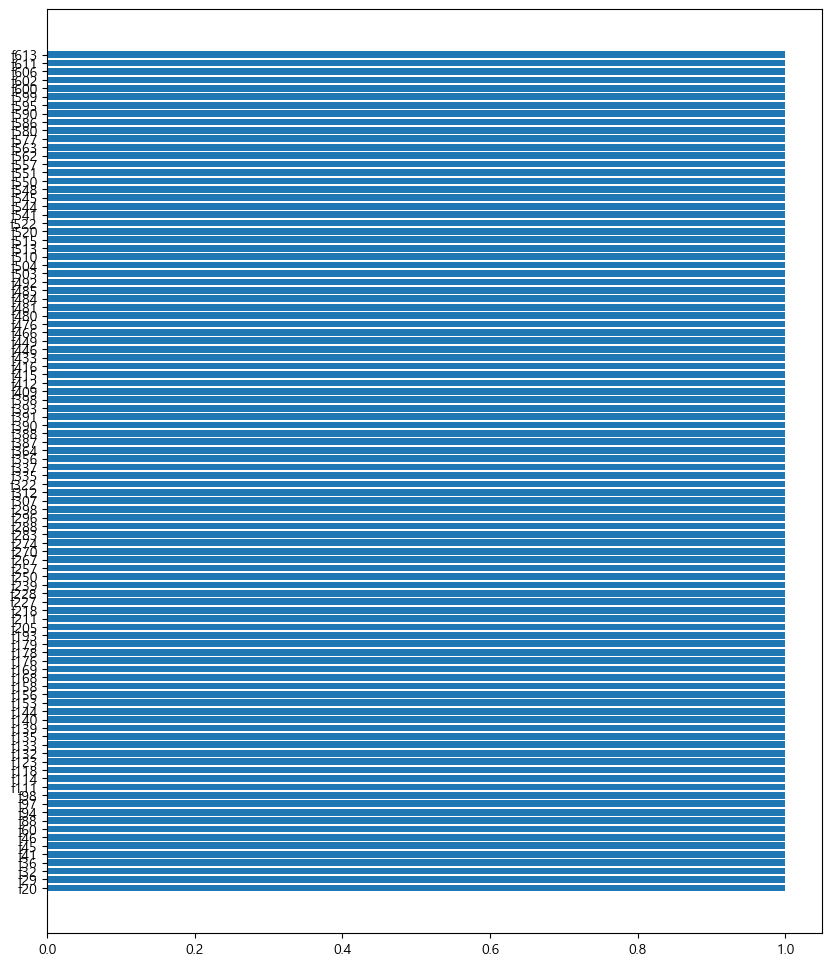

In [23]:
importance = models[-1].get_booster().get_score(importance_type="weight")
tuples = [(k, importance[k]) for k in importance]
tuples.sort(key=lambda x: x[1])

label, values = zip(*tuples)

plt.rcParams["font.family"] = "MalGun Gothic"
plt.figure(figsize=(10, 12))
plt.barh(label[:100], values[:100])
plt.show()

In [24]:
submit = pd.read_csv("./data/sample_submission.csv")
submit["MLM"] = y_tests[-1]
submit.to_csv("xgboost_optuna.csv", index=False)